# Dimensionality Reduction using PCA

#### This notebook was developed by [Dalya Baron](https://obs.carnegiescience.edu/dalya-baron)  for the Vatican Observatory Summer School 2023.
<br>
In this notebook we will learn about Principle Component Analysis and apply the PCA decomoposition to several datasets. We will then compare the results of the PCA decomposition to those of ICA and NNMF.

<a id='toc'></a>

## This notebook includes:

[(1) Basic PCA functionality using a simulated dataset](#EX1)

[(2) PCA decomposition of simulated galaxy spectra](#EX2)

[(3) Comparison of PCA to ICA and NNMF](#EX3)

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF

np.random.seed(42)
%matplotlib inline  

## (1) Basic PCA functionality using a simulated dataset<a id='EX1'></a>
[Go to top](#toc)<br><br>

We will start with a simple 2-dimensional dataset and apply PCA to it. The dataset will include 1000 objects, each with two features. We will draw the data from a multivariate normal distribution. 

shape of X:  (1000, 2)


Text(0, 0.5, 'x2')

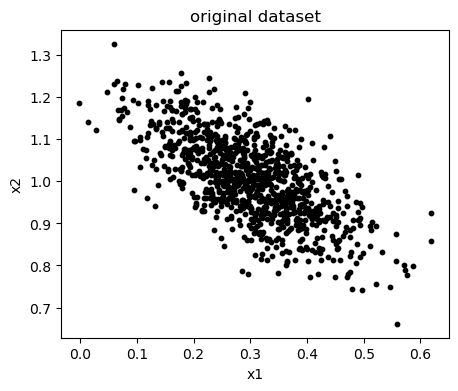

In [93]:
Nobj = 1000

mean = np.array([0.3, 1.0])
cov = np.array([[0.01, -0.007], [-0.007, 0.01]])
X = np.random.multivariate_normal(mean, cov, size=Nobj)
print("shape of X: ", X.shape)

# plot dataset
plt.figure(1, figsize=(5, 4))
plt.title("original dataset")
plt.scatter(X[:, 0], X[:, 1], c="k", s=10)
plt.xlabel("x1")
plt.ylabel("x2")

We will now apply PCA to this dataset. <br>
The principal components transformation can also be associated with another matrix factorization, the singular value decomposition (SVD). A nice youtube tutorial for SVD is available here in <a href="https://www.youtube.com/watch?v=gXbThCXjZFM" target="_blank">part-1</a> and <a href="https://www.youtube.com/watch?v=nbBvuuNVfco" target="_blank">part-2</a>).<br>

In general, the **maximum** number of principle components is `min(n_samples, n_features)`. For this dataset, we have 1000 samples and 2 features, so we will get 2 principle components. In the next example, we will work with a dataset with `n_samples` < `n_features`. 

In [94]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [95]:
print(pca.mean_)

[0.2991473  1.00526652]


Text(0, 0.5, 'x2')

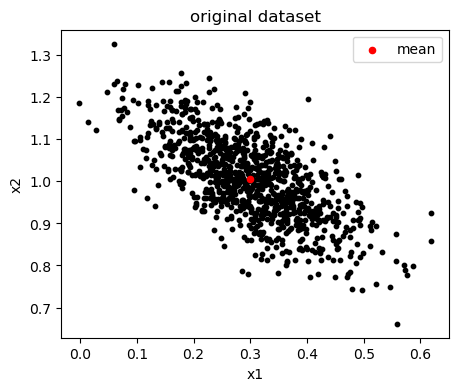

In [96]:
plt.figure(1, figsize=(5, 4))
plt.title("original dataset")
plt.scatter(X[:, 0], X[:, 1], c="k", s=10)
plt.scatter(pca.mean_[0], pca.mean_[1], c="r", s=20, label="mean")
plt.legend(loc="best")
plt.xlabel("x1")
plt.ylabel("x2")

In [97]:
# extract the variance of each of the components
variance = pca.explained_variance_
print("variance in the components: ", variance)

# explained variance ratio
print("explained variance ratio: ", pca.explained_variance_ratio_)

variance in the components:  [0.0157196 0.0030904]
explained variance ratio:  [0.83570438 0.16429562]


In [98]:
# extract the principle components
components = pca.components_
print("components: ", components)

components:  [[ 0.70609761 -0.70811452]
 [ 0.70811452  0.70609761]]


We will now plot the direction of the two principle components and compare it to the data. For that, we will start by subtracting the mean vector from every row in the dataset. For clarity, we will scale each principle component according to its variance and plot it.

Text(0, 0.5, 'x2')

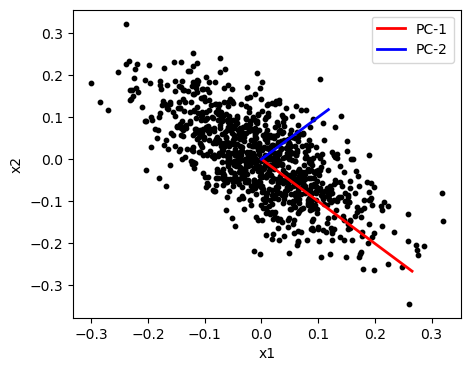

In [99]:
# zero mean dataset
X_zero_mean = X - pca.mean_

# scale the principle components by the variance using 3*sigma
comp_1 = components[0] * np.sqrt(variance[0]) * 3
comp_2 = components[1] * np.sqrt(variance[1]) * 3

plt.figure(1, figsize=(5, 4))

plt.scatter(X_zero_mean[:, 0], X_zero_mean[:, 1], c="k", s=10)
plt.plot([0, comp_1[0]], [0, comp_1[1]], "r", lw=2, label="PC-1")
plt.plot([0, comp_2[0]], [0, comp_2[1]], "b", lw=2, label="PC-2")

plt.legend(loc="best")
plt.xlabel("x1")
plt.ylabel("x2")

Now we will transform the data using the principle components.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1000, 2) (1000, 2)


Text(0, 0.5, 'x2')

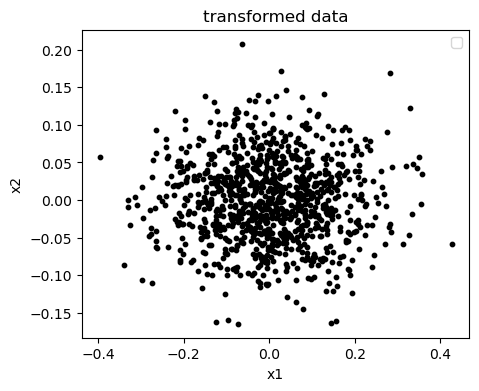

In [100]:
X_trans = pca.transform(X)
print(X.shape, X_trans.shape)

plt.figure(1, figsize=(5, 4))
plt.title("transformed data")
plt.scatter(X_trans[:, 0], X_trans[:, 1], c="k", s=10)
plt.legend(loc="best")
plt.xlabel("x1")
plt.ylabel("x2")

Lets make sure that we understand how the transformation works. The transformation is given by $V = Z \times P$, where $Z$ is the mean-subtracted data, $P$ is the eigenvector matrix, also called the loadings. The transformed data is $V$. The visual representation is as follows:

<div>
<img src="figures/PCA_trans_visual.png" width="400"/>
</div>

<br>

We will focus on the first row in the mean-subtracted data, which we will call $z_1$. Our eigenvector matrix is $P$. The transformed row is then $v_1 = z_1 \times P$. 

In [101]:
print("first row in mean-subtracted dataset: ", X_zero_mean[0])
print("first row in the transformed dataset: ", X_trans[0])

z_1 = X_zero_mean[0]
P = components.T

v_1 = np.matmul(z_1, P)
print("matrix multiplication result: ", v_1)

first row in mean-subtracted dataset:  [-0.05029703  0.03517331]
first row in the transformed dataset:  [-0.06042135 -0.01078027]
matrix multiplication result:  [-0.06042135 -0.01078027]


Lets apply the inverse transform. Since we used both of the principle components, we expect the inverse transform to result in exactly the same mean-subtracted matrix we started with. 

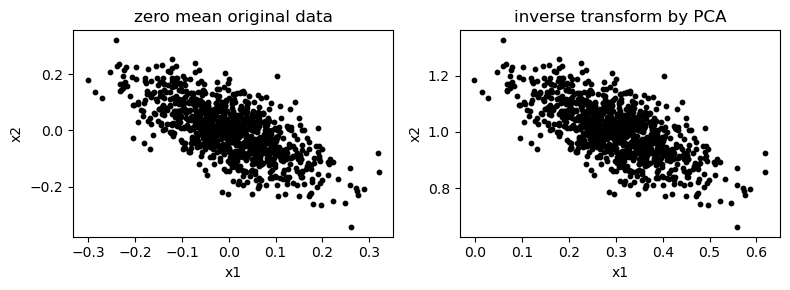

In [102]:
X_inverse_trans = pca.inverse_transform(X_trans)

# compare the two datasets
plt.figure(1, figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title("zero mean original data")
plt.scatter(X_zero_mean[:, 0], X_zero_mean[:, 1], c="k", s=10)
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1, 2, 2)
plt.title("inverse transform by PCA")
plt.scatter(X_inverse_trans[:, 0], X_inverse_trans[:, 1], c="k", s=10)
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()

### Note that the inverse transform by sklearn adds the mean vector back!!!

## Dimensionality reduction with PCA
In this example we worked with 2 features, so the maximum number of principle components is 2. By using both of the components, we essentially transformed the data into a different coordiante system, but kept all of the information. That is, we did not reduce the dimensionality of our data.

However, in the sklearn implementation of PCA we can select `n_components` < `min(n_samples, n_features)`, which means that we will apply dimensionality reduction to the data. Let's examine the results when selecting `n_components = 1`.

In [103]:
pca = PCA(n_components=1)
pca.fit(X)

PCA(n_components=1)

In [104]:
# extract the variance of each of the components
variance = pca.explained_variance_
print("variance in the components: ", variance)

# explained variance ratio
print("explained variance ratio: ", pca.explained_variance_ratio_)

# extract the principle components
components = pca.components_
print("components: ", components)

variance in the components:  [0.0157196]
explained variance ratio:  [0.83570438]
components:  [[ 0.70609761 -0.70811452]]


Text(0, 0.5, 'x2')

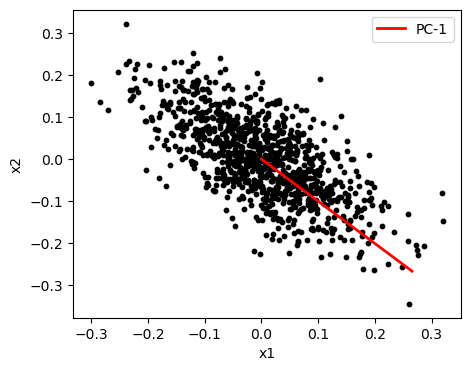

In [105]:
# zero mean dataset
X_zero_mean = X - pca.mean_

# scale the principle components by the variance using 3*sigma
comp_1 = components[0] * np.sqrt(variance[0]) * 3

plt.figure(1, figsize=(5, 4))

plt.scatter(X_zero_mean[:, 0], X_zero_mean[:, 1], c="k", s=10)
plt.plot([0, comp_1[0]], [0, comp_1[1]], "r", lw=2, label="PC-1")

plt.legend(loc="best")
plt.xlabel("x1")
plt.ylabel("x2")

Let's transform the data using only one component. What will happen?

In [106]:
X_trans = pca.transform(X)
print(X.shape, X_trans.shape)

(1000, 2) (1000, 1)


Now let's apply the inverse transform. In this case we do expect that some information will be lost, as we reduced the dimension of the data from 2 to 1. 

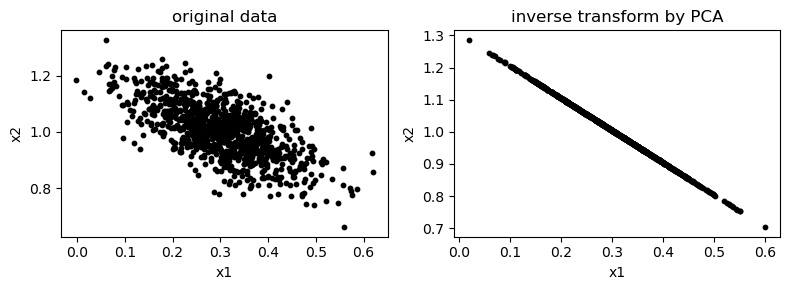

In [107]:
X_inverse_trans = pca.inverse_transform(X_trans)

# compare the two datasets
plt.figure(1, figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title("original data")
plt.scatter(X[:, 0], X[:, 1], c="k", s=10)
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1, 2, 2)
plt.title("inverse transform by PCA")
plt.scatter(X_inverse_trans[:, 0], X_inverse_trans[:, 1], c="k", s=10)
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()

## Homework, if you'd like
1. Take the dataset and add an outlier with varying degree of difference from the population mean. For example, try an outlier that is 10$\sigma$ away from the mean, and then try an outlier that is 1000$\sigma$ away from the mean. Apply PCA and examine the resulting principle components. By how much to they change?
2. Simulate a simple 2-d dataset with two classes. Apply PCA and examine the resulting principle components.

## (2) PCA decomposition of simulated galaxy spectra<a id='EX2'></a>
[Go to top](#toc)<br><br>

In this part of the notebook we will simulate galaxy spectra using two SSP models from the MILES library. We will: 
- Apply PCA to the dataset and will examine the explained variance ratio, which will allow us to select how many principle components we want to work with. 
- Examine the resulting principle components and will try to interpret them.
- Apply dimensionality reduction, and then the inverse transform, and will compare between the original spectra and those obtained after the dimensionality reduction.

Text(0, 0.5, 'flux [a.u]')

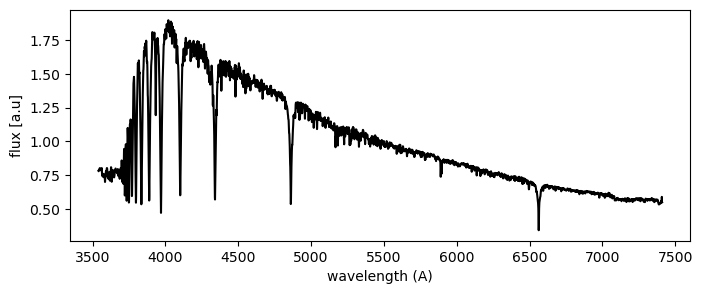

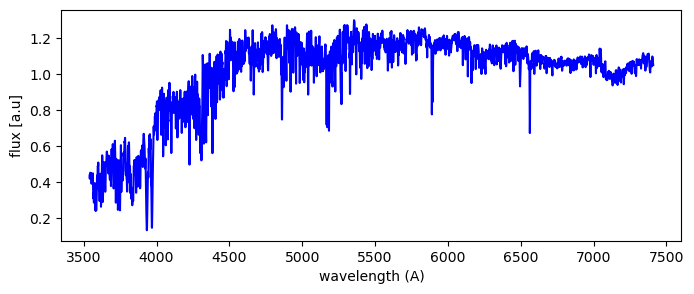

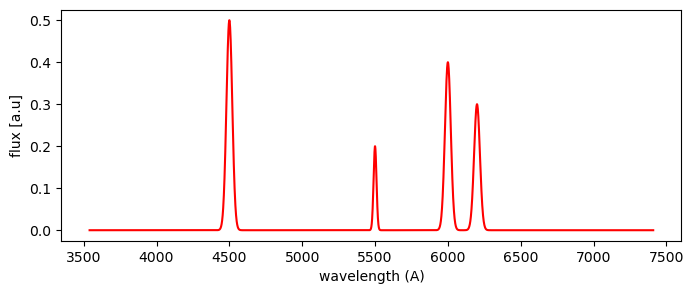

In [113]:
# load two stellar spectra from the data directory
# one star is of age 0.3 Gyr, and the second of 4 Gyr

# template wavelength
wavelength = np.arange(3540.5, 7409.6 + 0.9, 0.9)

# stellar spectra
path1 = "data/MILES_models/Mch1.30Zp0.06T00.3000_iTp0.00_baseFe_linear_FWHM_2.51.fits"
h1 = fits.open(path1)
spectrum1 = h1[0].data

path2 = "data/MILES_models/Mch1.30Zp0.06T04.0000_iTp0.00_baseFe_linear_FWHM_2.51.fits"
h2 = fits.open(path2)
spectrum2 = h2[0].data

# emission line spectrum
emission_line_spectrum = numpy.zeros(len(wavelength))
wavelength_list = [4500., 5500., 6000.0, 6200.0]
amp_list = [0.5, 0.2, 0.4, 0.3]
std_list = [20.0, 10.0, 20.0, 20.0]
for i in range(len(wavelength_list)):
    emission_line_spectrum += amp_list[i] * numpy.exp(-(wavelength - wavelength_list[i])**2/(2*std_list[i]**2))

# plot the two spectra
plt.figure(1, figsize=(8, 3))
plt.plot(wavelength, spectrum1/spectrum1.mean(), "k", label="0.3 Gyr")
plt.xlabel("wavelength (A)")
plt.ylabel("flux [a.u]")

plt.figure(2, figsize=(8, 3))
plt.plot(wavelength, spectrum2/spectrum2.mean(), "b", label="4 Gyr")
plt.xlabel("wavelength (A)")
plt.ylabel("flux [a.u]")

plt.figure(3, figsize=(8, 3))
plt.plot(wavelength, emission_line_spectrum, "r", label="gas emission")
plt.xlabel("wavelength (A)")
plt.ylabel("flux [a.u]")
#plt.legend(loc="best")

We will now create a sample of 200 galaxies. Each simulated galaxy will be a sum of these three spectra, where the weight of the different spectra changes from object to object. This means that our dataset will have 200 objects (rows), and 4300 features (this is the number of wavelengths in the spectra; columns).

In [115]:
n_sample = 200
spectrum1_norm = spectrum1/spectrum1.mean()
spectrum2_norm = spectrum2/spectrum2.mean()

spectra_list = []
for i in range(n_sample):
    # different weights for the different components
    w1 = np.random.uniform(0, 1)
    w2 = np.random.uniform(0, 1)
    w_emission_lines = np.random.uniform(0, 2)
    
    final_spectrum = w1 * spectrum1_norm + w2 * spectrum2_norm + w_emission_lines * emission_line_spectrum
    spectra_list.append(final_spectrum)
    
X = np.copy(spectra_list)
print("shape of the dataset: ", X.shape)

shape of the dataset:  (200, 4300)


Plot a random subset of 5 simulated galaxies

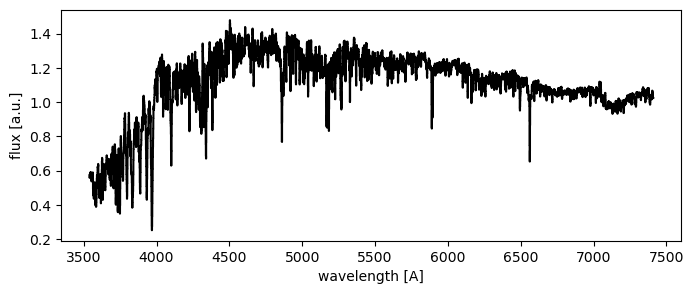

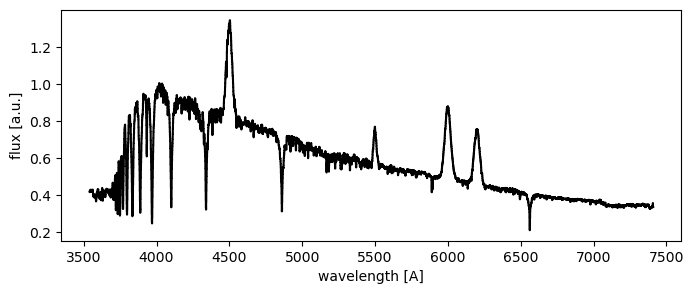

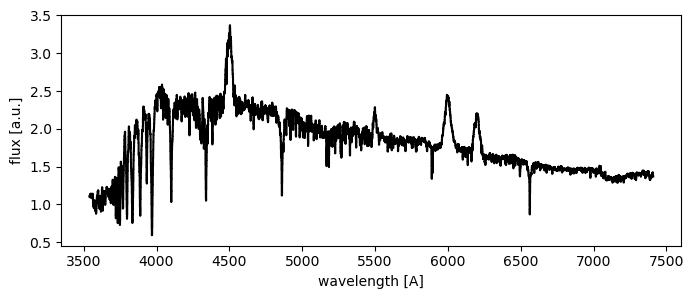

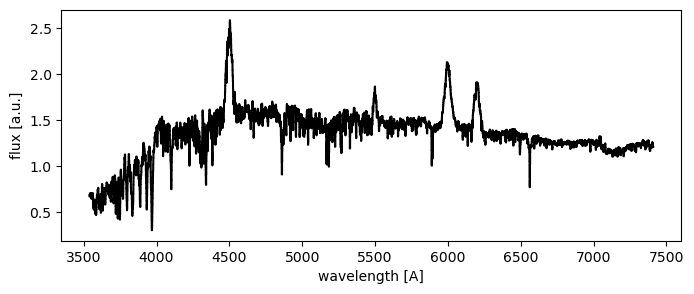

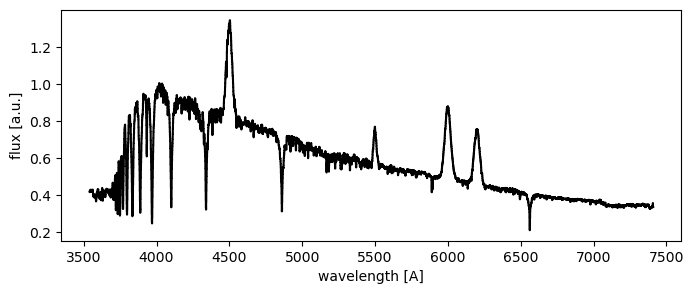

In [119]:
for i in range(5):
    rand_ind = np.random.randint(0, len(X)-1, 1)
    rand_spec = X[rand_ind, :].flatten()
    
    plt.figure(i + 1, figsize=(8, 3))
    plt.step(wavelength, rand_spec, "k")
    plt.xlabel("wavelength [A]")
    plt.ylabel("flux [a.u.]")

Let's apply PCA to this dataset. The maximum number of components we can select is 200, since this is `min(n_samples, n_features)`. We will select 20, but you can feel free to examine different number of components later! 

In [120]:
pca = PCA(n_components=20)
pca.fit(X)

PCA(n_components=20)

explained variance ratio:  [9.32211109e-01 5.92665833e-02 8.52230777e-03 1.56026677e-16
 1.38274426e-16 1.25802045e-16 1.13960841e-16 1.07597060e-16
 1.03676022e-16 1.00801152e-16 1.00411957e-16 9.90465467e-17
 9.57737006e-17 9.43639343e-17 9.26610748e-17 9.21565611e-17
 8.82947546e-17 8.59684529e-17 8.38552732e-17 8.37173439e-17]


Text(0, 0.5, 'explained variance ratio')

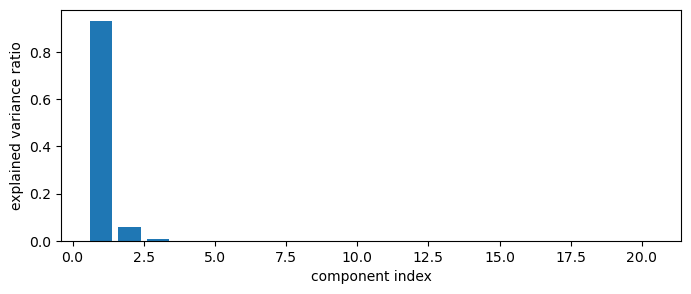

In [123]:
# plot the explained variance ratio for the 20 components

explained_variance_ratio = pca.explained_variance_ratio_
print("explained variance ratio: ", explained_variance_ratio)

plt.figure(1, figsize=(8, 3))
plt.bar(np.arange(len(explained_variance_ratio)) + 1, explained_variance_ratio)
plt.xlabel("component index")
plt.ylabel("explained variance ratio")

Note that all but the first three components are practically zero. The PCA has identified that the dimensionality of the data is 3. This is incredible!!!!

<div>
<img src="figures/patrick-star-spongebob-squarepants.gif" width="400"/>
</div>

Let's plot the mean spectrum, and the 7 first principle components.

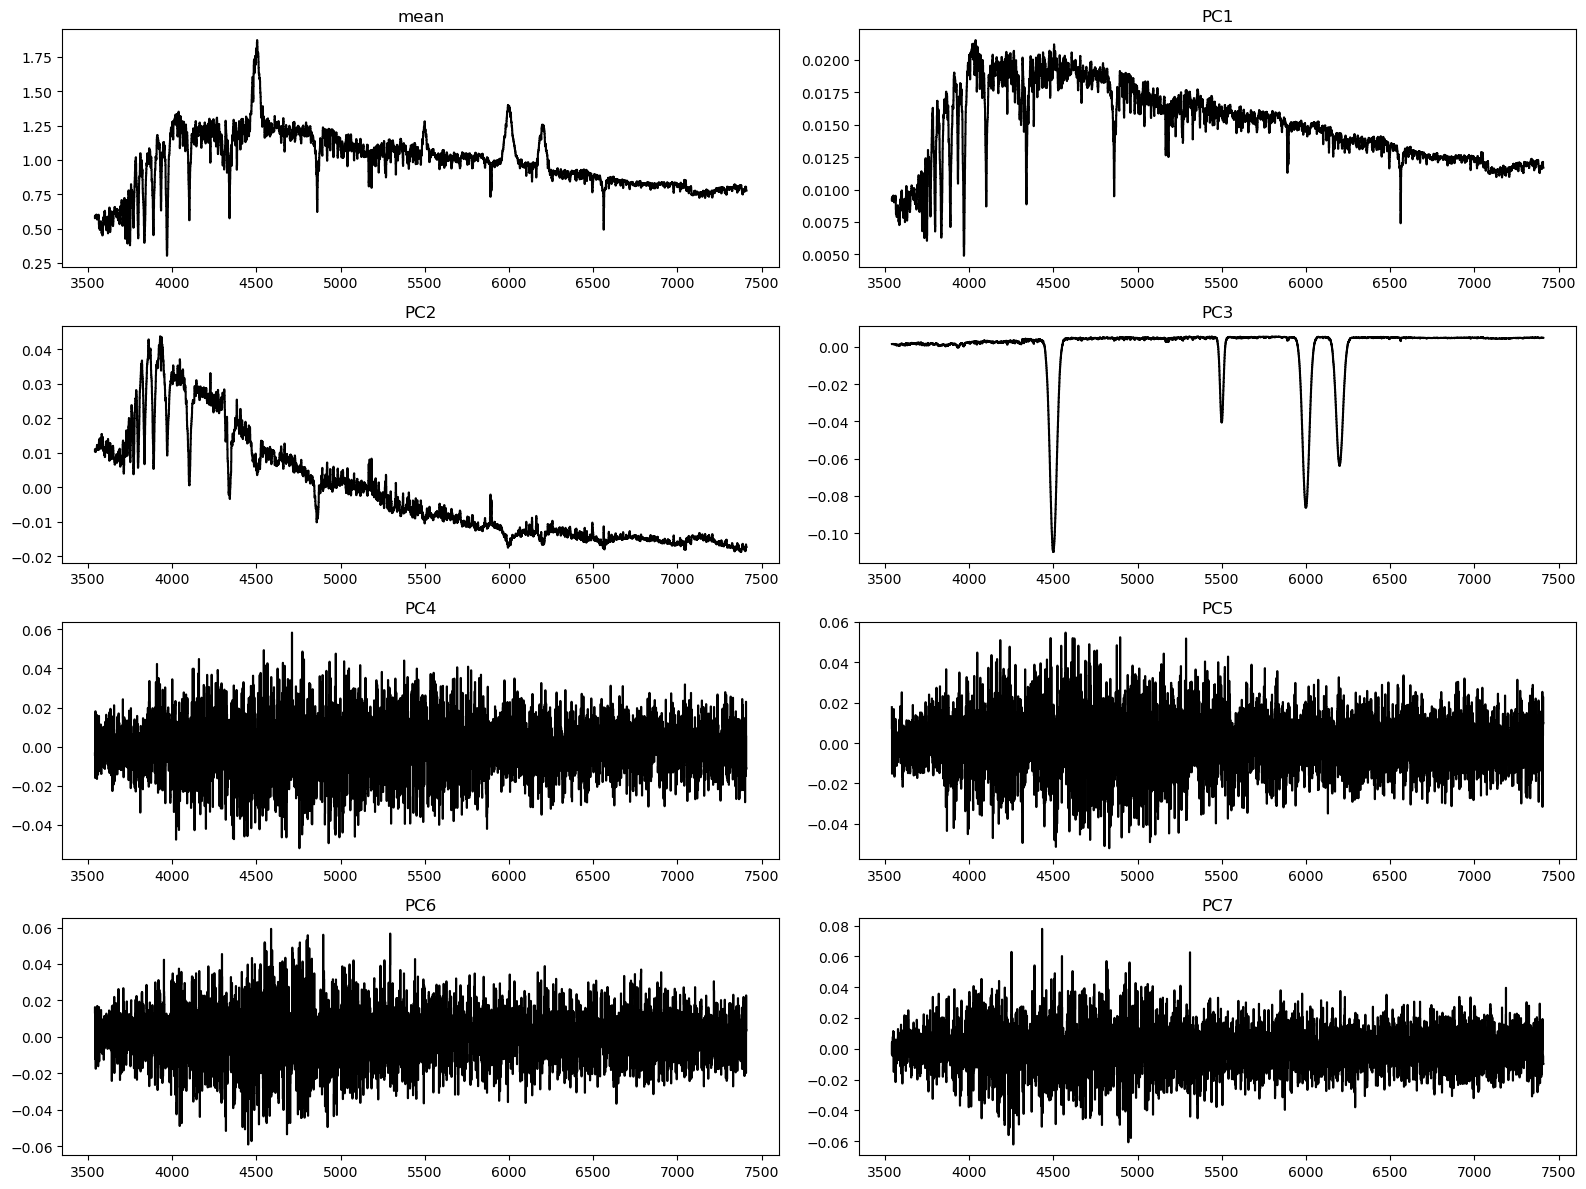

In [131]:
mean = pca.mean_
components =  pca.components_

plt.figure(1, figsize=(16, 12))

plt.subplot(4, 2, 1)
plt.title("mean")
plt.step(wavelength, mean, "k")


for i in range(7):
    plt.subplot(4, 2, 2 + i)
    plt.title("PC%s" % int(i+1))
    plt.step(wavelength, components[i], "k")
    
plt.tight_layout()

### Dimensionality reduction of the simulated spectra

We will use PCA to reduce the dimensionality of the data to 3 dimensions. We will then:
- Plot the location of the simulated galaxies in the 3-d space.
- Compare between the original spectra and the inverse-transform spectra to see whether information has been lost (it should not, given the variances we have seen before). 

In [132]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

(200, 4300) (200, 3)


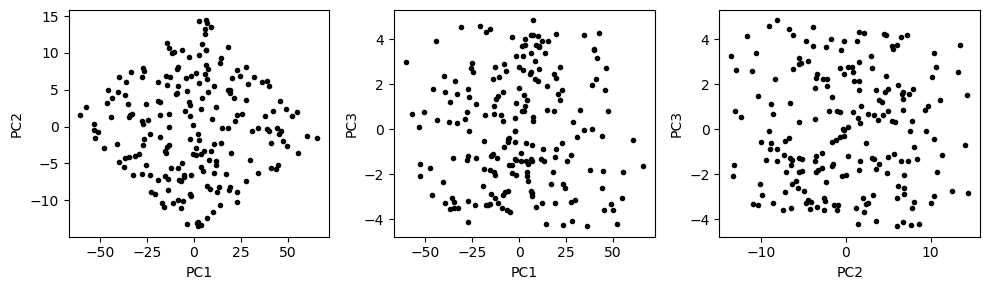

In [134]:
X_trans = pca.transform(X)
print(X.shape, X_trans.shape)

pc1_loc = X_trans[:, 0]
pc2_loc = X_trans[:, 1]
pc3_loc = X_trans[:, 2]

plt.figure(1, figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.plot(pc1_loc, pc2_loc, ".k")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 3, 2)
plt.plot(pc1_loc, pc3_loc, ".k")
plt.xlabel("PC1")
plt.ylabel("PC3")

plt.subplot(1, 3, 3)
plt.plot(pc2_loc, pc3_loc, ".k")
plt.xlabel("PC2")
plt.ylabel("PC3")

plt.tight_layout()

**Task**: go back to where the data was simulated, and changed the distribution from which the weights were drawn. Check what is the effect on this diagram.

For a random subset of galaxies, plot the original simulated spectrum and compare it to the inverse transform using only 3 principle components.

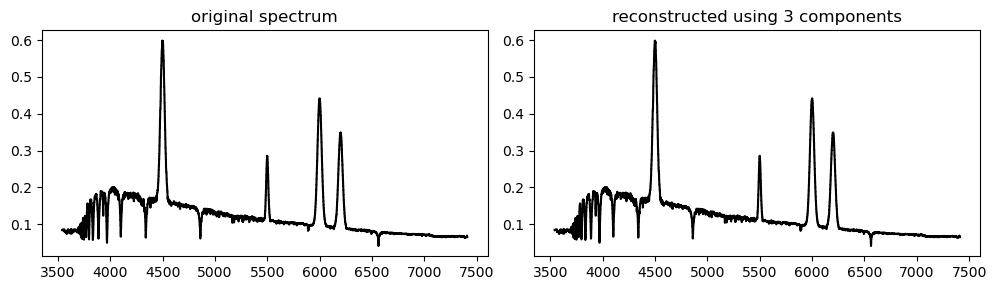

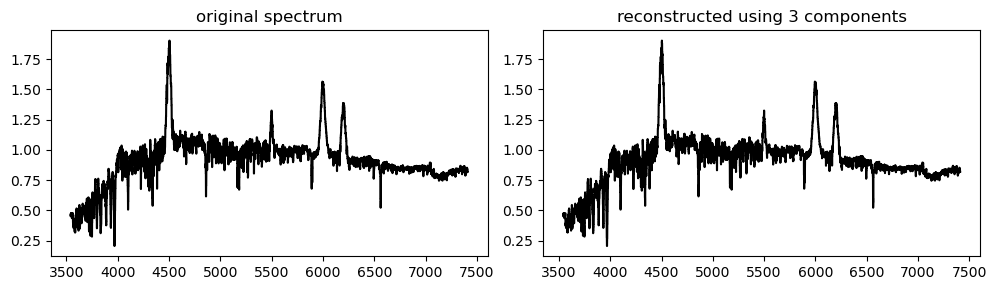

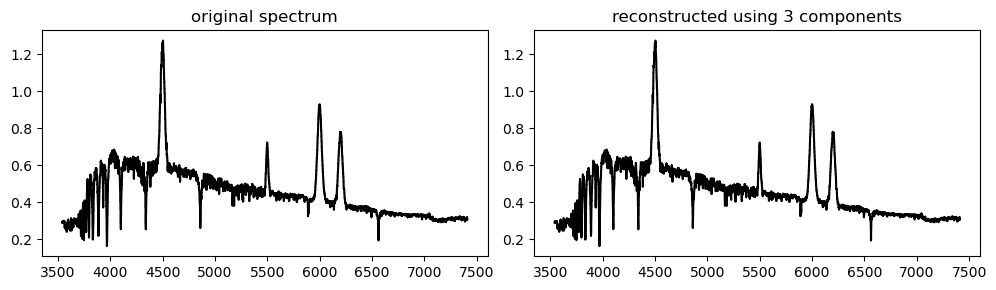

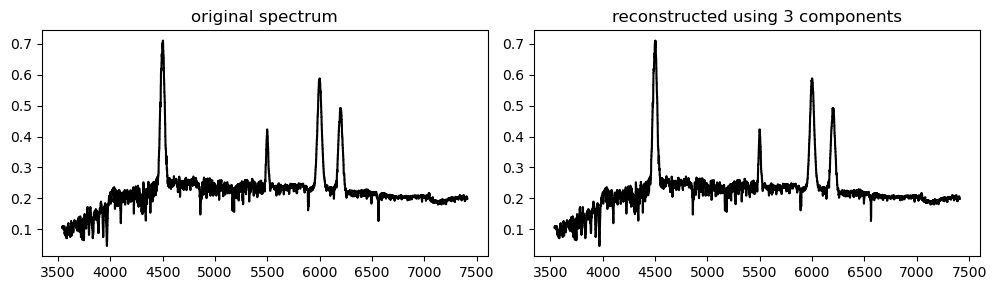

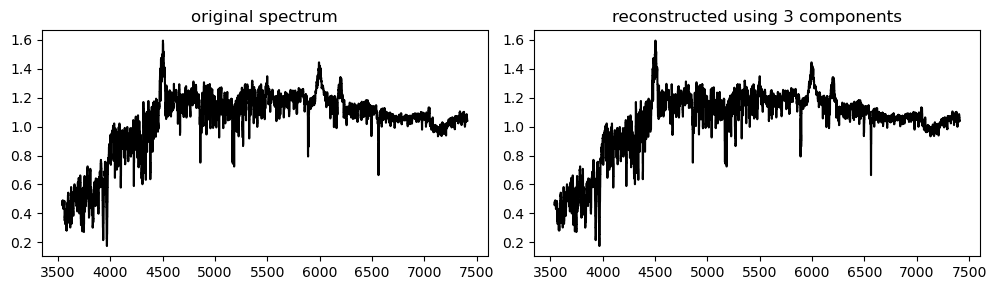

In [137]:
X_inverse_trans = pca.inverse_transform(X_trans)

rand_inds = np.random.randint(0, 200-1, 5)

for i, rand_ind in enumerate(rand_inds):
    
    plt.figure(i + 1, figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.title("original spectrum")
    plt.step(wavelength, X[rand_ind, :], "k")
    
    plt.subplot(1, 2, 2)
    plt.title("reconstructed using 3 components")
    plt.step(wavelength, X_inverse_trans[rand_ind, :], "k")
    
    plt.tight_layout()

### Try the same, but with 2 instead of 3 components

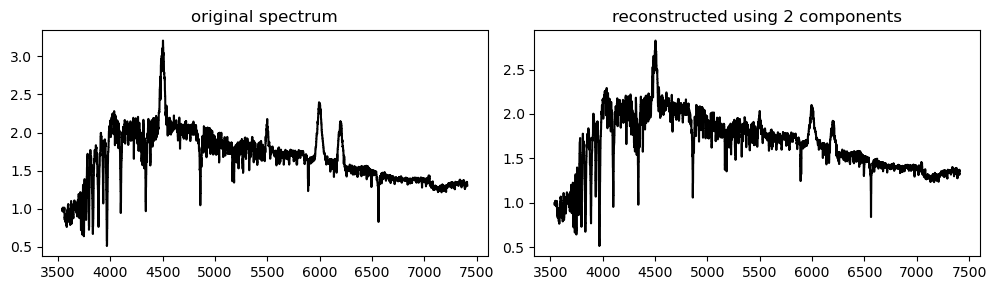

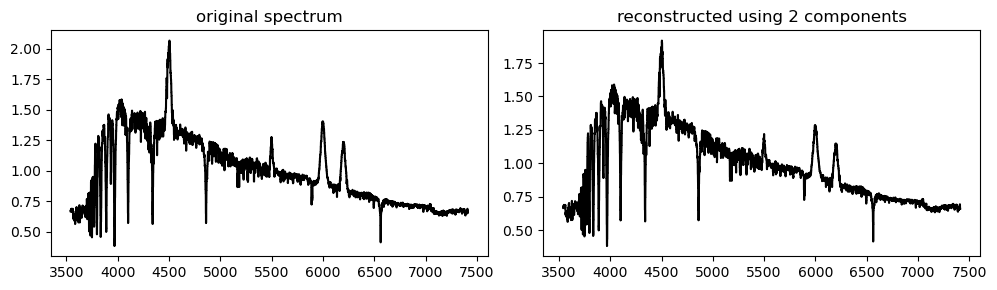

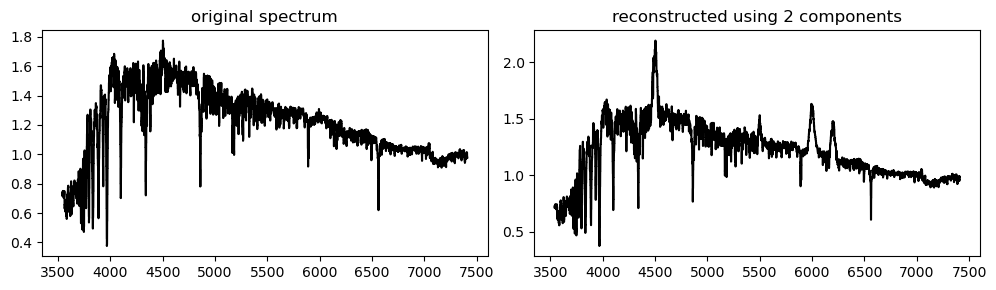

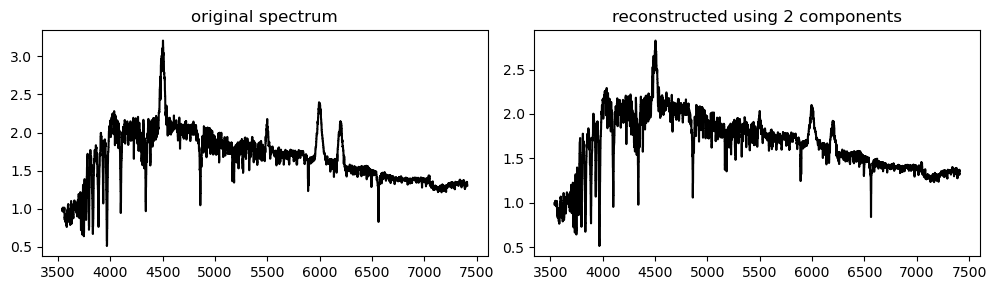

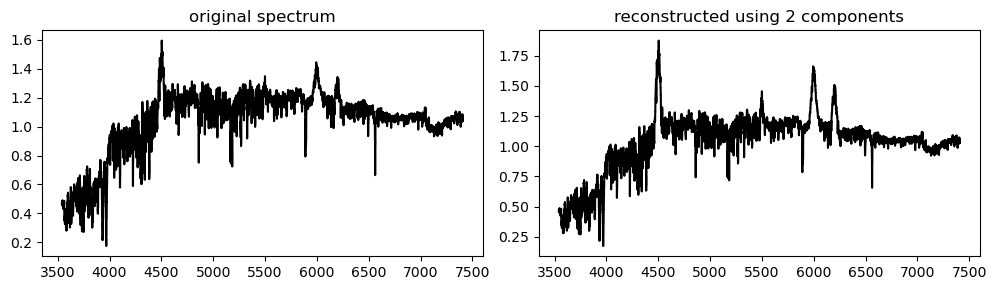

In [138]:
pca = PCA(n_components=2)
pca.fit(X)
X_trans = pca.transform(X)

X_inverse_trans = pca.inverse_transform(X_trans)

rand_inds = np.random.randint(0, 200-1, 5)

for i, rand_ind in enumerate(rand_inds):
    
    plt.figure(i + 1, figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.title("original spectrum")
    plt.step(wavelength, X[rand_ind, :], "k")
    
    plt.subplot(1, 2, 2)
    plt.title("reconstructed using 2 components")
    plt.step(wavelength, X_inverse_trans[rand_ind, :], "k")
    
    plt.tight_layout()

## (3) Comparison of PCA to ICA and NNMF<a id='EX3'></a>
[Go to top](#toc)<br><br>

This code was taken from Jake VanderPlas's Jupyter notebook. For more information, you can go <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html" target="_blank">here</a> or <a href="https://www.arxiv-vanity.com/papers/1411.5039/" target="_blank">here</a>.

In this part of the notebook we will compare the principle components derived using PCA, ICA, and NNMF.

In [143]:
# now, examine the decomposition by the different methods
spectra_list = np.array(spectra_list)
spectra_mean = spectra_list.mean(0)

# PCA
pca = PCA(n_components=5)
pca.fit(spectra_list)
pca_comp = np.vstack([spectra_mean, pca.components_])
print(pca_comp.shape)

# ICA
ica = FastICA(5)
ica.fit(spectra_list.T)
ica_comp = np.vstack([spectra_mean, ica.transform(spectra_list.T).T])
print(ica_comp.shape)

# NMF
spectra_list[spectra_list < 0] = 0
nmf = NMF(6)
nmf.fit(spectra_list)
nmf_comp = nmf.components_
print(nmf_comp.shape)

(6, 4300)
(6, 4300)


/Users/dalyabaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


(6, 4300)


/Users/dalyabaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


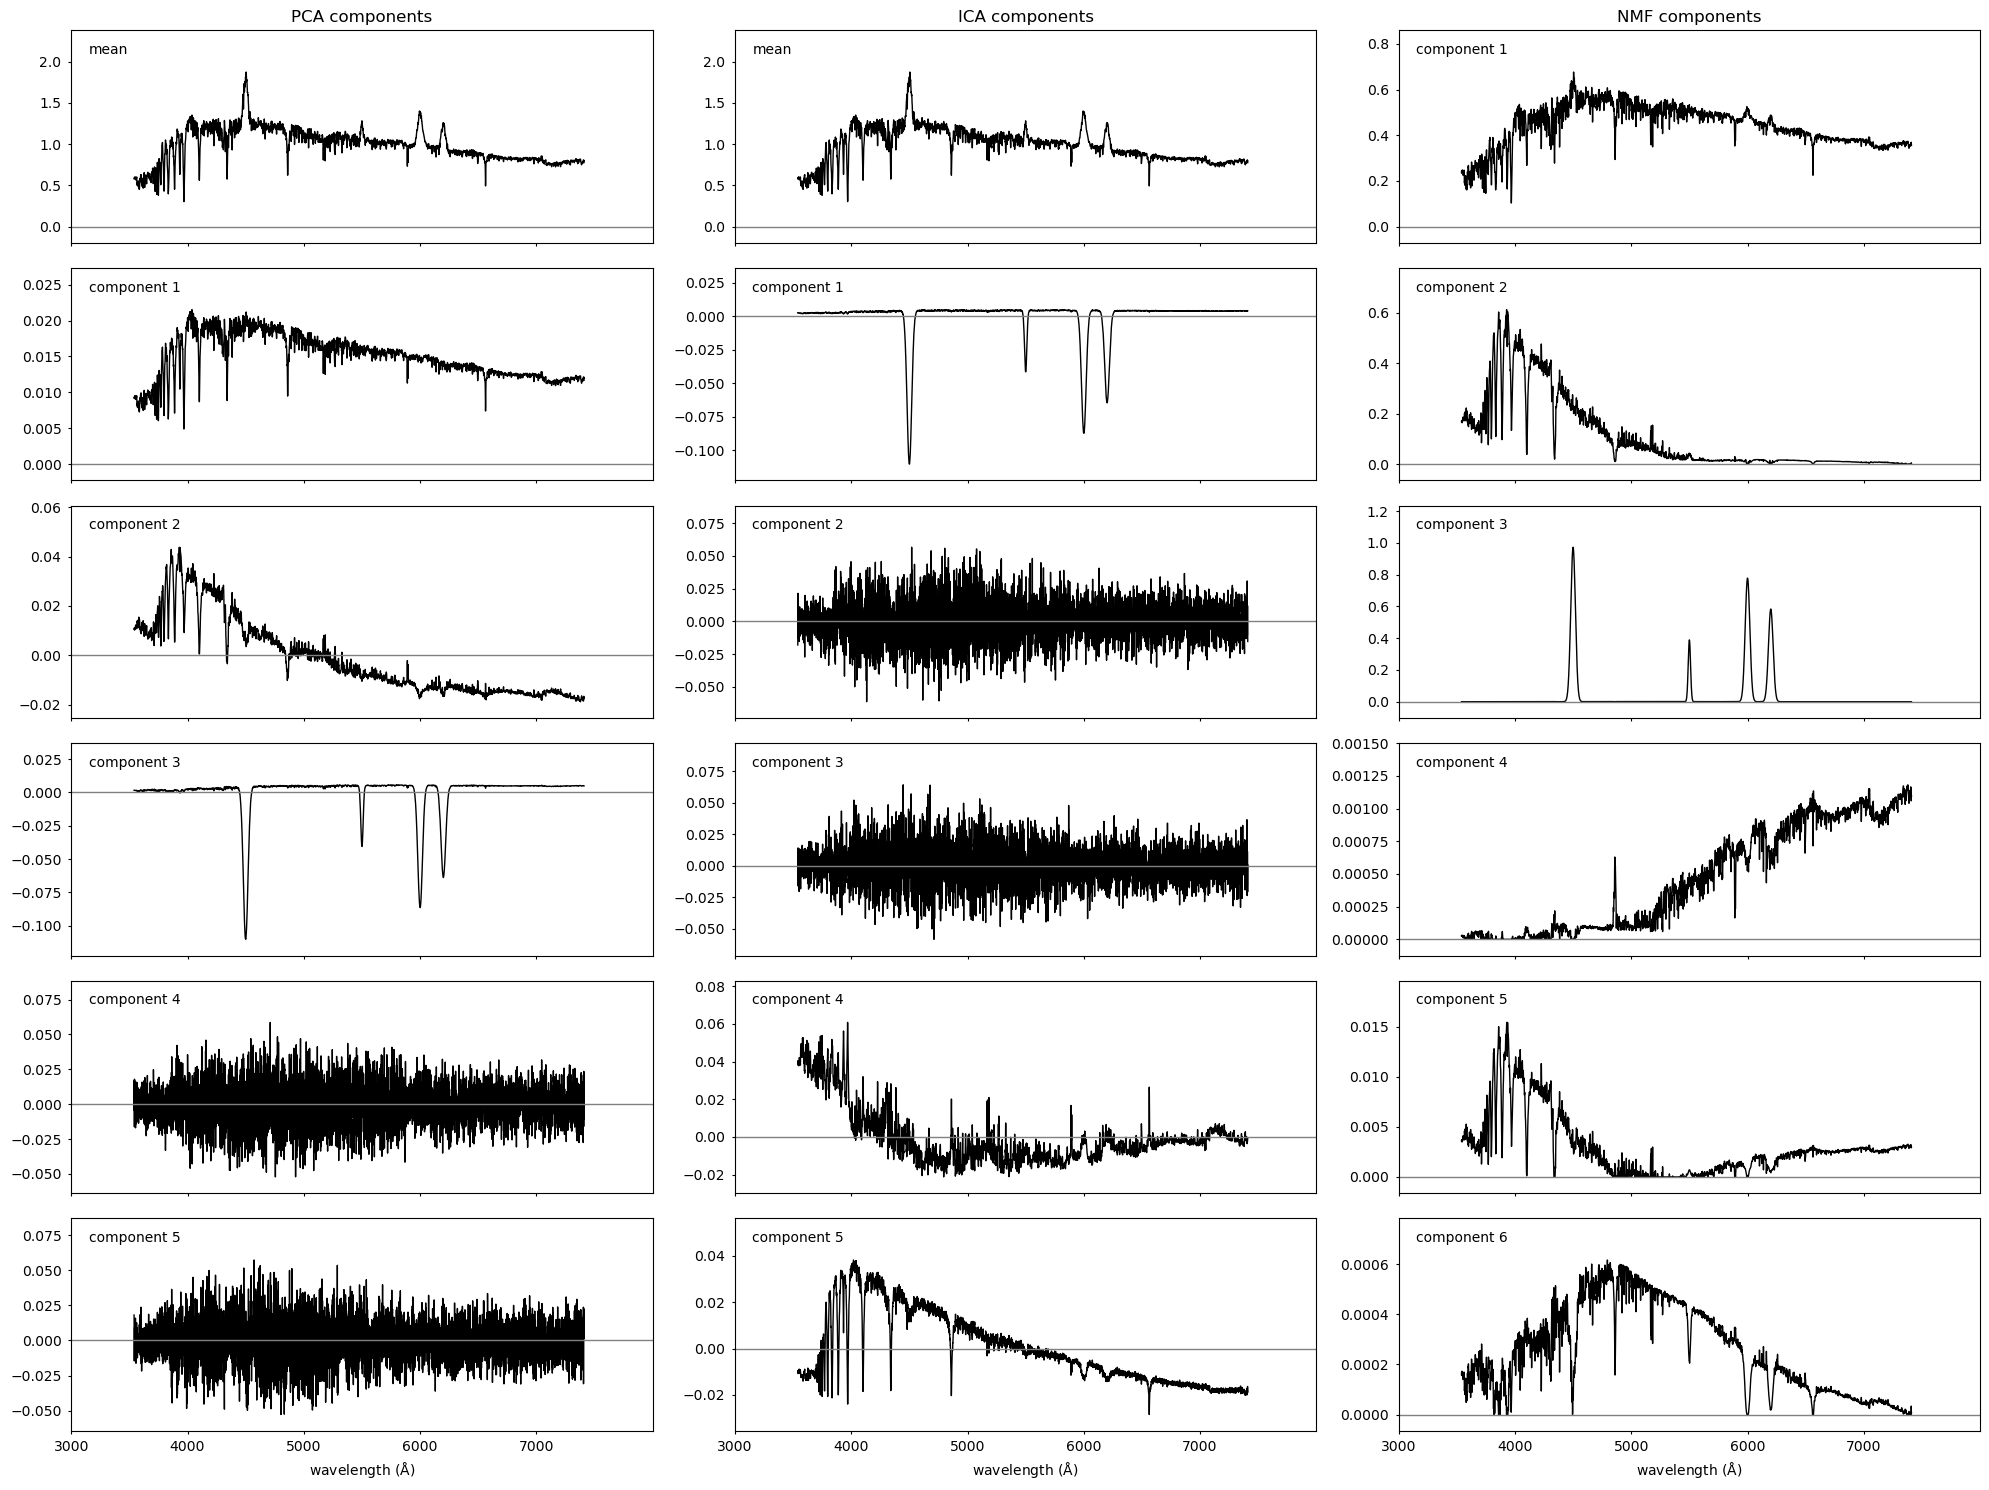

In [144]:
n_components = 6
decompositions = [pca_comp, ica_comp, nmf_comp]

fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        #ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelength, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 7999]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
        ax.set_xlim(xlim)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines(): 
            l.set_markersize(2) 

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

plt.tight_layout()
plt.show()